# CORDEXBench: A benchmarking dataset for regional climate downscaling

CORDEXBench [1] is a standardized benchmarking dataset designed to evaluate empirical-statistical downscaling (ESD) methods and deep learning-based regional climate emulators. It enables rigorous model evaluation across multiple climate zones and experimental setups. In this notebook, we demonstrate its usage by training and evaluating the DeepESD model [2], using the deep4downscaling library [3].

In [1]:
import os
import zipfile
import xarray as xr
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

import sys; sys.path.append('/home/jovyan/work/deep4downscaling')
import deep4downscaling.viz
import deep4downscaling.trans
import deep4downscaling.deep.loss
import deep4downscaling.deep.utils
import deep4downscaling.deep.models
import deep4downscaling.deep.train
import deep4downscaling.deep.pred
import deep4downscaling.metrics
import deep4downscaling.metrics_ccs

So far the following two geographic domains are available:

- New Zealand (NZ) - 0.11° resolution
- Europe (ALPS) - 0.11° resolution

To demonstrate how to work with the data, we will use the dataset for NNZ as an example. Applying the same approach to the ALPS region is straightforward, as the data is formatted in nearly the same way.

In [2]:
domain = 'NZ' # (ALPS, NZ)

We create some folders to save the data and the trained models.

In [3]:
DATA_PATH = f'./data/CORDEXBench/{domain}/{domain}_domain'
MODELS_PATH = f'./models/CORDEXBench/{domain}'

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

## CORDEXBench Data Download

The data is available on Zenodo [1] as a .zip file for each region. In the following cell, we automate the download of these files based on the selected domain.

In [5]:
if domain == 'ALPS':
    !wget -P ./data/CORDEXBench/ALPS https://zenodo.org/records/15797226/files/ALPS_domain.zip?download=1
    !mv ./data/CORDEXBench/ALPS/ALPS_domain.zip* ./data/CORDEXBench/ALPS/ALPS_domain.zip 
    
    with zipfile.ZipFile('./data/CORDEXBench/ALPS/ALPS_domain.zip', 'r') as zip_ref:
        zip_ref.extractall('./data/CORDEXBench/ALPS')
    
    !rm ./data/CORDEXBench/ALPS/ALPS_domain.zip 
    
elif domain == 'NZ':
    !wget -P ./data/CORDEXBench/NZ https://zenodo.org/records/15797226/files/NZ_domain.zip?download=1
    !mv ./data/CORDEXBench/NZ/NZ_domain.zip* ./data/CORDEXBench/NZ/NZ_domain.zip 
    
    with zipfile.ZipFile('./data/CORDEXBench/NZ/NZ_domain.zip', 'r') as zip_ref:
        zip_ref.extractall('./data/CORDEXBench/NZ')
    
    !rm ./data/CORDEXBench/NZ/NZ_domain.zip 

--2025-07-07 07:10:24--  https://zenodo.org/records/15797226/files/NZ_domain.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4445802927 (4.1G) [application/octet-stream]
Saving to: ‘./data/CORDEXBench/NZ/NZ_domain.zip?download=1’

NZ_domain.zip?downl 100%[===================>]   4.14G  17.1MB/s    in 8m 12s  

2025-07-07 07:18:36 (8.62 MB/s) - ‘./data/CORDEXBench/NZ/NZ_domain.zip?download=1’ saved [4445802927/4445802927]



## Training Experiment

The dataset provides two core training experiments:

- **ESD Pseudo-Reality (1961–1980)**: A 20-year historical training period using a single GCM (e.g., ACCESS-CM2 for NZ), designed to mimic ESD training. 

- **Emulator Hist+Future (1961–1980 + 2081–2100)**: A more comprehensive 40-year training period combining historical and future climates. This experiment supports evaluation of extrapolative skill, including transferability across GCMs.

In [4]:
training_experiment = 'ESD_pseudo_reality' # (ESD-pseudo-reality, Emulator_hist_fut)

# Set the period
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_fut':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

Depending on the domain, the corresponding Regional Climate Model (RCM) will be nested within a different Global Climate Model (GCM).

In [5]:
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ':
    gcm_name = 'ACCESS-CM2'

The goal is to emulate both the 2m maximum temperature (tasmax) and precipitation (pr). For clarity, this notebook will focus on maximum temperature, which will be our target variable.

In [6]:
target_var = 'tasmax' # (tasmax, pr)

The predictors include meridional and zonal wind components, specific humidity, air temperature, and geopotential height at 850, 700, and 500 hPa.

In [7]:
predictor_filename = f'{DATA_PATH}/train/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
predictor = xr.open_dataset(predictor_filename)
print(predictor)

<xarray.Dataset> Size: 112MB
Dimensions:  (time: 7300, lat: 16, lon: 16)
Coordinates:
  * lon      (lon) float64 128B 157.5 159.5 161.5 163.5 ... 183.5 185.5 187.5
  * lat      (lat) float64 128B -55.5 -53.5 -51.5 -49.5 ... -29.5 -27.5 -25.5
  * time     (time) datetime64[ns] 58kB 1961-01-01 1961-01-02 ... 1980-12-31
Data variables: (12/15)
    u_850    (time, lat, lon) float32 7MB ...
    u_700    (time, lat, lon) float32 7MB ...
    u_500    (time, lat, lon) float32 7MB ...
    v_850    (time, lat, lon) float32 7MB ...
    v_700    (time, lat, lon) float32 7MB ...
    v_500    (time, lat, lon) float32 7MB ...
    ...       ...
    t_850    (time, lat, lon) float32 7MB ...
    t_700    (time, lat, lon) float32 7MB ...
    t_500    (time, lat, lon) float32 7MB ...
    z_850    (time, lat, lon) float32 7MB ...
    z_700    (time, lat, lon) float32 7MB ...
    z_500    (time, lat, lon) float32 7MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.5 (ht

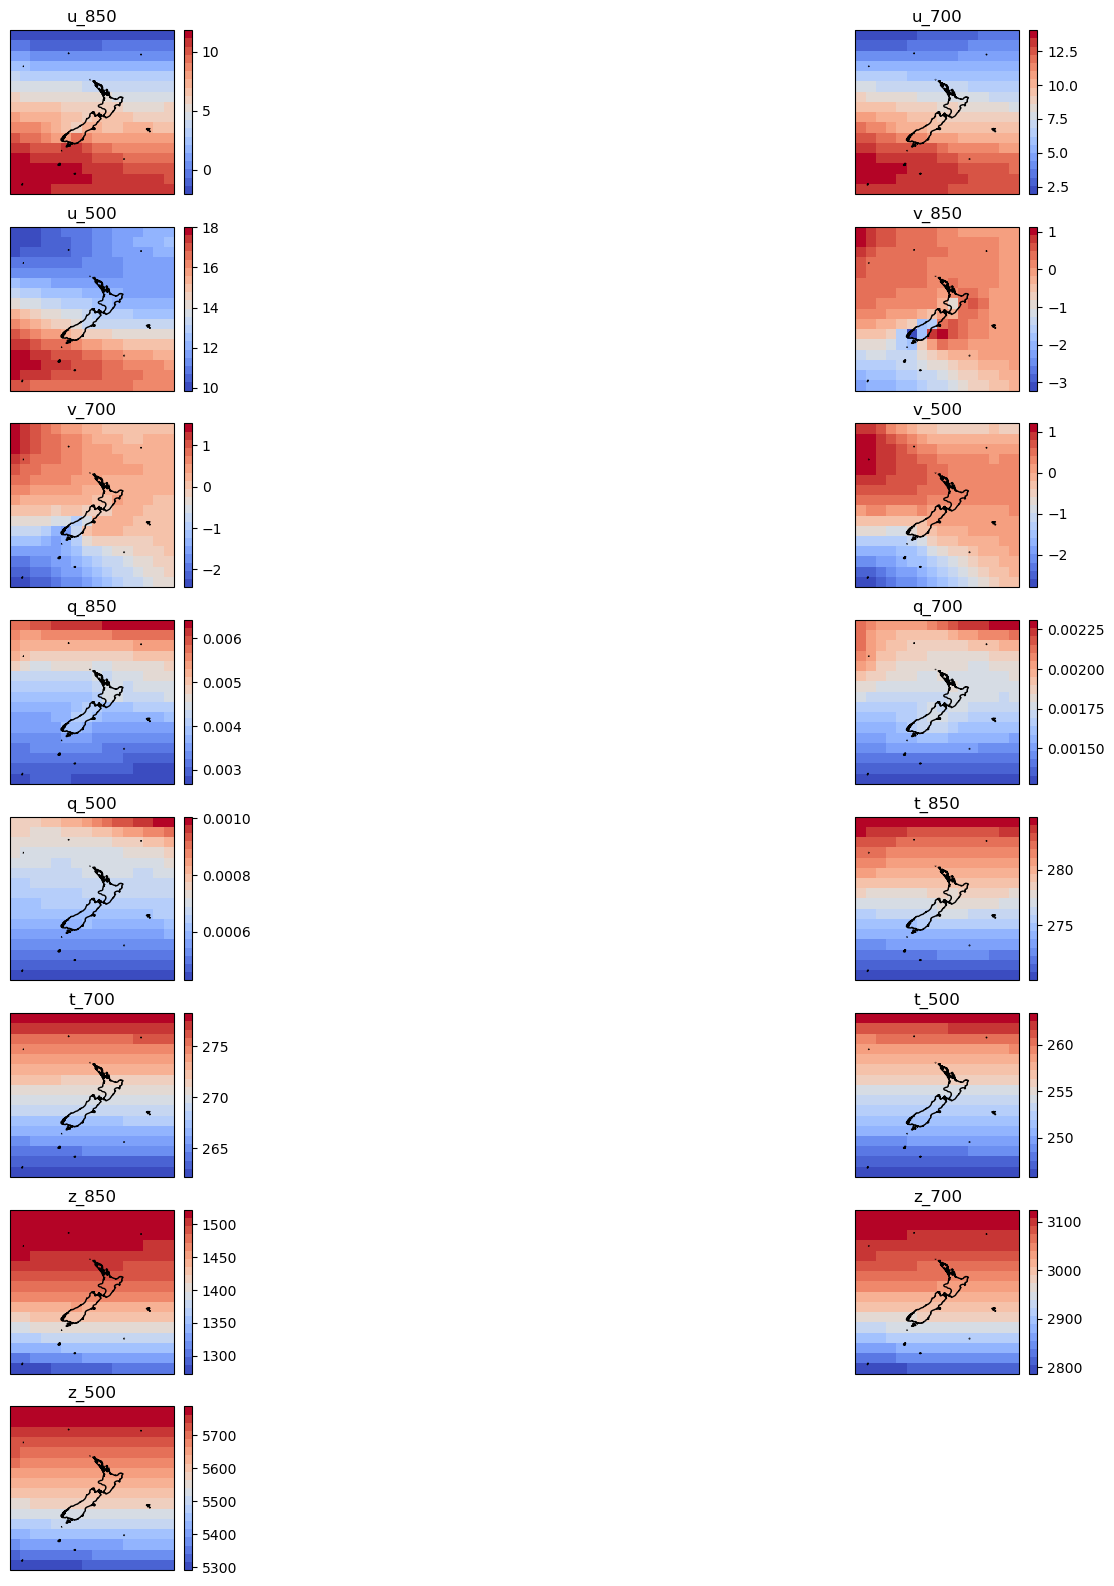

In [8]:
if domain == 'ALPS':
    central_longitude = 0
elif domain == 'NZ':
    central_longitude = 180
    
deep4downscaling.viz.multiple_map_plot(data=predictor.mean('time'),
                                       central_longitude=central_longitude)

The benchmark also includes orography at the predictand's resolution to be used as a covariate; however, it is not used in this notebook.

In [45]:
orog_path =  f'{DATA_PATH}/train/{training_experiment}/predictors/Static_fields.nc'
orog = xr.open_dataset(orog_path)
orog = orog[['orog']]
print(orog)

<xarray.Dataset> Size: 67kB
Dimensions:  (lat: 128, lon: 128)
Coordinates:
  * lon      (lon) float32 512B 166.0 166.1 166.3 166.4 ... 179.5 179.6 179.7
  * lat      (lat) float32 512B -47.56 -47.46 -47.35 ... -34.15 -34.04 -33.93
Data variables:
    orog     (lat, lon) float32 66kB ...
Attributes: (12/322)
    source:               CSIRO conformal-cubic model. Input file: ccam_12km....
    Conventions:          CF-1.7
    title:                CCAM simulation data
    contact:              ccam@csiro.au
    project:              Undefined CCAM project
    history:              Created on 2022-06-11 14:37:10
    ...                   ...
    expdesc:              CCAM model run
    version:              CCAM r5251:5254M
    nproc:                864
    procmode:             10
    decomp:               face
    modeling_realm:       atmos


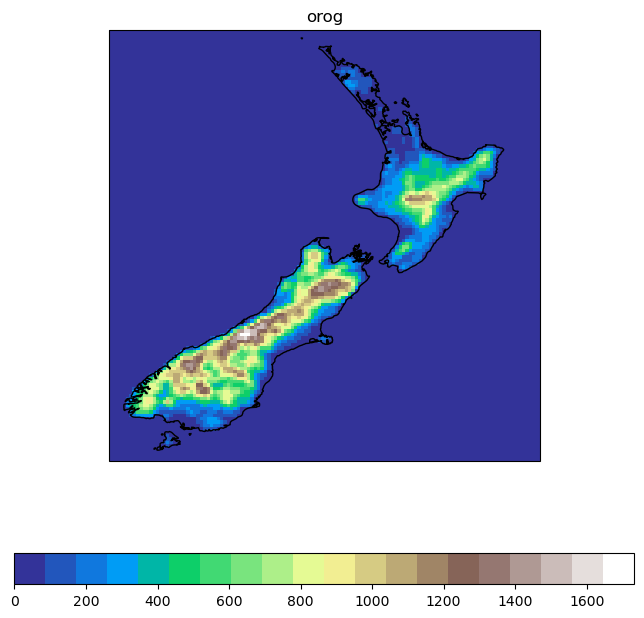

In [46]:
deep4downscaling.viz.simple_map_plot(data=orog,
                                     colorbar='terrain', var_to_plot='orog')

We load the target (predictand) in the same way.

In [9]:
predictand_filename = f'{DATA_PATH}/train/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
predictand = xr.open_dataset(predictand_filename)
predictand = predictand[[target_var]]
print(predictand)

<xarray.Dataset> Size: 478MB
Dimensions:  (time: 7300, lat: 128, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 58kB 1961-01-01 1961-01-02 ... 1980-12-31
  * lon      (lon) float32 512B 166.0 166.1 166.3 166.4 ... 179.5 179.6 179.7
  * lat      (lat) float32 512B -47.56 -47.46 -47.35 ... -34.15 -34.04 -33.93
Data variables:
    tasmax   (time, lat, lon) float32 478MB ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co

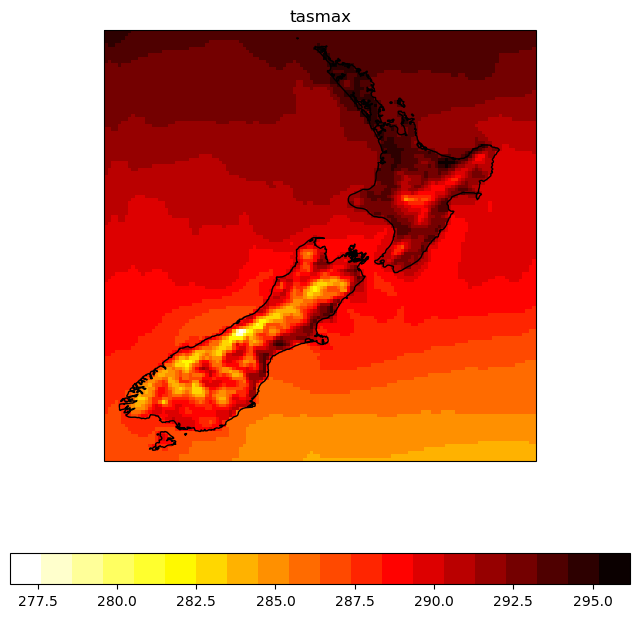

In [10]:
deep4downscaling.viz.simple_map_plot(data=predictand.isel(time=100),
                                     colorbar='hot_r', var_to_plot=target_var)

Leveraging deep4downscaling library we perform some preprocessing over the data

In [11]:
# Remove days with nans in the predictor
predictor = deep4downscaling.trans.remove_days_with_nans(predictor)

# Align both datasets in time
predictor, predictand = deep4downscaling.trans.align_datasets(predictor, predictand, 'time')

There are no observations containing null values


For clarity, we split the data into separate training and test sets (note that the selection depends on the specific training experiment).

In [13]:
if training_experiment == 'ESD_pseudo_reality':
    years_train = list(range(1961, 1975))
    years_test = list(range(1975, 1980+1))
elif training_experiment == 'Emulator_hist_fut':
    years_train = list(range(1961, 1980+1)) + list(range(2080, 2090))
    years_test = list(range(2090, 2099+1))

x_train = predictor.sel(time=np.isin(predictor['time'].dt.year, years_train))
y_train = predictand.sel(time=np.isin(predictand['time'].dt.year, years_train))

x_test = predictor.sel(time=np.isin(predictor['time'].dt.year, years_test))
y_test = predictand.sel(time=np.isin(predictand['time'].dt.year, years_test))

As is standard practice, we standardize the predictors.

In [14]:
x_train_stand = deep4downscaling.trans.standardize(data_ref=x_train, data=x_train)

The deep4downscaling library expects the output to be a flat vector, so we flatten our target `xr.DataArray`. Note that the names of the spatial dimensions vary depending on the domain. This is because the ALPS data uses a Lambert projection but can still be processed as a square array. This is the only difference between the data from the two domains.

In [15]:
if domain == 'ALPS':
    spatial_dims = ('x', 'y')
elif domain == 'NZ':
    spatial_dims = ('lat', 'lon')

y_train_stack = y_train.stack(gridpoint=spatial_dims)

We select the Mean Squared Error (MSE) as loss function

In [16]:
loss_function = deep4downscaling.deep.loss.MseLoss(ignore_nans=False)

And transform the xarray data to NumPy arrays

In [17]:
x_train_stand_arr = deep4downscaling.trans.xarray_to_numpy(x_train_stand)
y_train_arr = deep4downscaling.trans.xarray_to_numpy(y_train_stack)

As deep4downscaling is based on PyTorch we need to define the Datasets and DataLoaders for training the model

In [18]:
# Create Dataset
train_dataset = deep4downscaling.deep.utils.StandardDataset(x=x_train_stand_arr,
                                                            y=y_train_arr)

# Split into training and validation sets
train_dataset, valid_dataset = random_split(train_dataset,
                                            [0.9, 0.1])

# Create DataLoaders
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,
                              shuffle=True)

We select the DeepESD architecture

In [20]:
model_name = f'DeepESD_{training_experiment}_{target_var}'
model = deep4downscaling.deep.models.DeepESDtas(x_shape=x_train_stand_arr.shape,
                                                y_shape=y_train_arr.shape,
                                                filters_last_conv=1,
                                                stochastic=False)
print(model)

DeepESDtas(
  (conv_1): Conv2d(15, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(25, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Linear(in_features=256, out_features=16384, bias=True)
)


Finally, we set the hyperparameters and train the model using a GPU.

In [21]:
# Set some hyperparameters
num_epochs = 10000
patience_early_stopping = 20

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

In [22]:
# Set the training device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Train the model
train_loss, val_loss = deep4downscaling.deep.train.standard_training_loop(
                            model=model, model_name=model_name, model_path=MODELS_PATH,
                            device=device, num_epochs=num_epochs,
                            loss_function=loss_function, optimizer=optimizer,
                            train_data=train_dataloader, valid_data=valid_dataloader,
                            patience_early_stopping=patience_early_stopping)

To compute predictions on the test set, we first standardize the test data using the statistics calculated from the training data as a reference.

In [25]:
# Load the model weights into the DeepESD architecture
model.load_state_dict(torch.load(f'{MODELS_PATH}/{model_name}.pt'))

# Standardize the test data
x_test_stand = deep4downscaling.trans.standardize(data_ref=x_train, data=x_test)

To compute predictions, we need to provide deep4downscaling with an xarray mask, which it uses as a template to apply the raw values returned by the PyTorch model.

In [26]:
y_mask = xr.ones_like(y_train.isel(time=0))

And we compute the predictions on the test set

In [27]:
if domain == 'ALPS':
    spatial_dims = ('x', 'y')
elif domain == 'NZ':
    spatial_dims = ('lat', 'lon')
    
pred_test = deep4downscaling.deep.pred.compute_preds_standard(
                                x_data=x_test_stand, model=model,
                                device=device, var_target=target_var,
                                mask=y_mask, batch_size=16,
                                spatial_dims=spatial_dims)

Deep4downscaling includes a standard set of validation metrics that are straightforward to apply, requiring only the ground-truth data (target) and the predictions, both as `xr.Datasets`. In the following cell, we provide an example of how to compute the mean bias, as well as the bias at the 2nd and 98th percentiles.

In [28]:
bias_mean = deep4downscaling.metrics.bias_mean(target=y_test, pred=pred_test,
                                               var_target=target_var) 

bias_p02 = deep4downscaling.metrics.bias_quantile(target=y_test, pred=pred_test,
                                                  quantile=0.02, var_target=target_var)

bias_p98 = deep4downscaling.metrics.bias_quantile(target=y_test, pred=pred_test,
                                                  quantile=0.98, var_target=target_var)

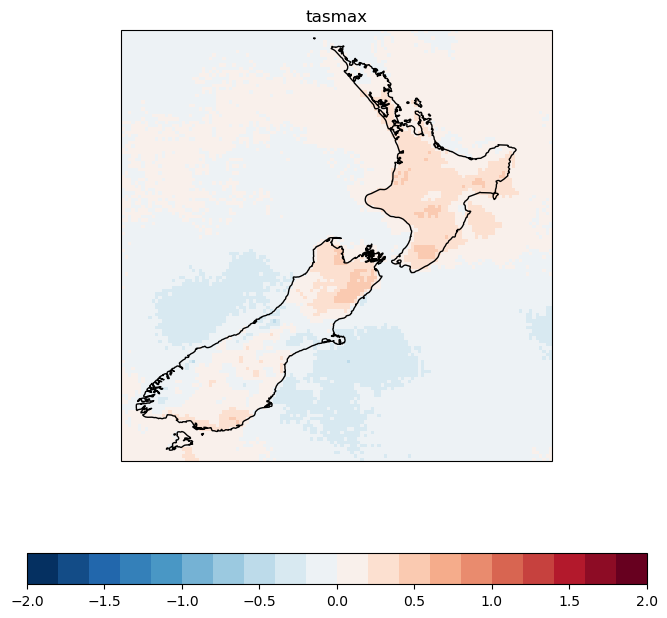

In [29]:
deep4downscaling.viz.simple_map_plot(data=bias_mean, var_to_plot=target_var,
                                     colorbar='RdBu_r', vlimits=(-2, 2))

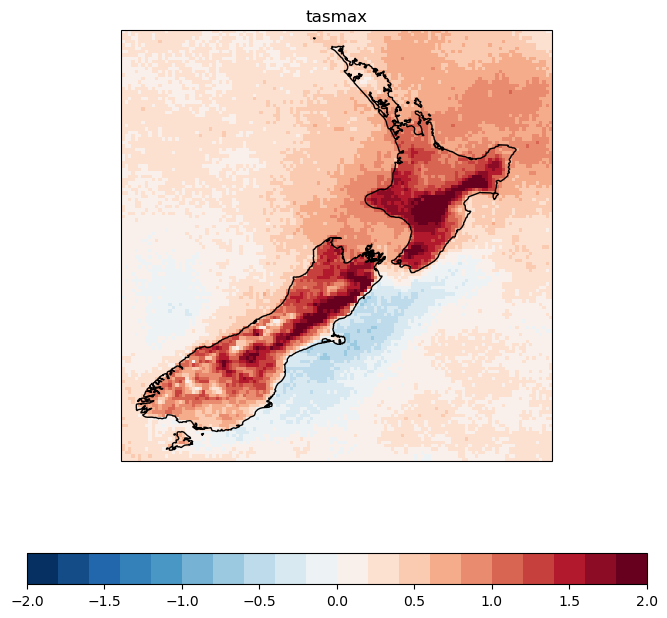

In [30]:
deep4downscaling.viz.simple_map_plot(data=bias_p02, var_to_plot=target_var,
                                     colorbar='RdBu_r', vlimits=(-2, 2))

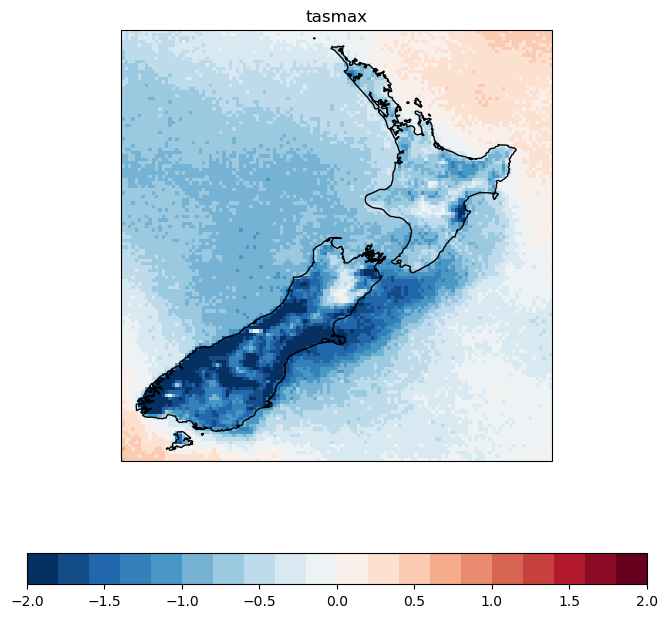

In [31]:
deep4downscaling.viz.simple_map_plot(data=bias_p98, var_to_plot=target_var,
                                     colorbar='RdBu_r', vlimits=(-2, 2))

### Evaluation Experiment

For each training setup, the dataset enables evaluation across multiple test periods and inference conditions:

- **Historical (1981–2000)**: For both perfect and imperfect inference.
- **Mid-century (2041–2060) and End-century (2081–2100)**: To assess extrapolation to future climates, including hard transferability scenarios using unseen GCMs.

In [33]:
evaluation_experiment = 'end_century' # (historical, mid_century, end_century)
mode = 'imperfect' # (imperfect, perfect)

In [34]:
# Choose the proper GCM
# NZ: ACCESS-CM2 (perfect) or EC-Earth3 (imperfect)
# ALPS: CNRM-CM5 (perfect) or MPI-ESM-LR (imperfect)

if mode == 'perfect':
    if domain == 'NZ':
        gcm_name = 'ACCESS-CM2'
    elif domain == 'ALPS':
        gcm_name = 'CNRM-CM5'
elif mode == 'imperfect':
    if domain == 'NZ':
        gcm_name = 'EC-Earth3'
    elif domain == 'ALPS':
        gcm_name = 'MPI-ESM-LR'

In [35]:
# Set the period
if evaluation_experiment == 'historical':
    period_evaluation = '1981-2000'
elif evaluation_experiment == 'mid_century':
    period_evaluation = '2041-2060'
elif evaluation_experiment == 'end_century':
    period_evaluation = '2080-2099'
else:
    raise ValueError('Provide a valid date')

We load and standardize the corresponding predictors.

In [37]:
predictor_evaluation_filename = f'{DATA_PATH}/test/{evaluation_experiment}/predictors/{mode}/{gcm_name}_{period_evaluation}.nc'
predictor_evaluation = xr.open_dataset(predictor_evaluation_filename)
print(predictor_evaluation)

<xarray.Dataset> Size: 112MB
Dimensions:  (time: 7300, lat: 16, lon: 16)
Coordinates:
  * time     (time) datetime64[ns] 58kB 2080-01-01 2080-01-02 ... 2099-12-31
  * lon      (lon) float64 128B 157.5 159.5 161.5 163.5 ... 183.5 185.5 187.5
  * lat      (lat) float64 128B -55.5 -53.5 -51.5 -49.5 ... -29.5 -27.5 -25.5
Data variables: (12/15)
    u_850    (time, lat, lon) float32 7MB ...
    u_700    (time, lat, lon) float32 7MB ...
    u_500    (time, lat, lon) float32 7MB ...
    v_850    (time, lat, lon) float32 7MB ...
    v_700    (time, lat, lon) float32 7MB ...
    v_500    (time, lat, lon) float32 7MB ...
    ...       ...
    t_850    (time, lat, lon) float32 7MB ...
    t_700    (time, lat, lon) float32 7MB ...
    t_500    (time, lat, lon) float32 7MB ...
    z_850    (time, lat, lon) float32 7MB ...
    z_700    (time, lat, lon) float32 7MB ...
    z_500    (time, lat, lon) float32 7MB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.5 (h

In [38]:
predictor_evaluation_stand = deep4downscaling.trans.standardize(data_ref=x_train, data=predictor_evaluation)

And compute the predictions

In [39]:
if domain == 'ALPS':
    spatial_dims = ('x', 'y')
elif domain == 'NZ':
    spatial_dims = ('lat', 'lon')

pred_evaluation = deep4downscaling.deep.pred.compute_preds_standard(
                                    x_data=predictor_evaluation_stand, model=model,
                                    device=device, var_target=target_var,
                                    mask=y_mask, batch_size=16,
                                    spatial_dims=spatial_dims)

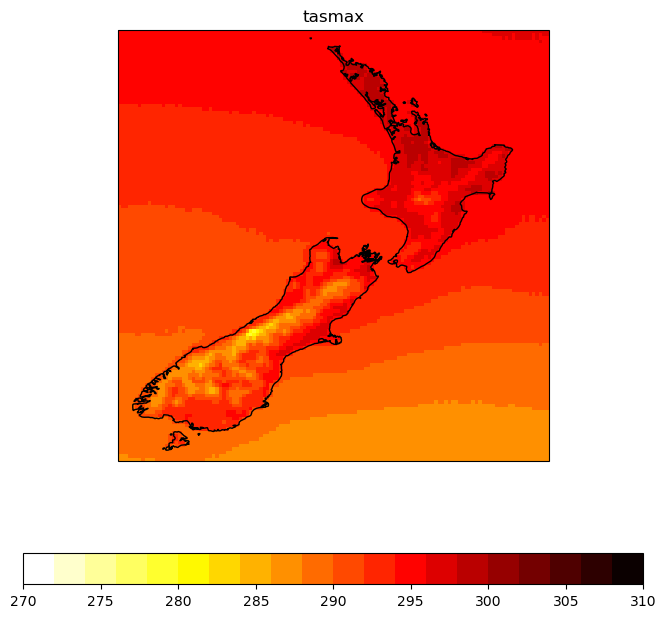

In [40]:
# Plot the climatology of the prediction
deep4downscaling.viz.simple_map_plot(data=pred_evaluation.mean('time'), var_to_plot=target_var,
                                     colorbar='hot_r', vlimits=(270, 310))

# References 

[1] https://zenodo.org/records/15797226

[2] Baño-Medina, J., Manzanas, R., Cimadevilla, E., Fernández, J., González-Abad, J., Cofiño, A. S., & Gutiérrez, J. M. (2022). Downscaling multi-model climate projection ensembles with deep learning (DeepESD): contribution to CORDEX EUR-44. Geoscientific Model Development Discussions, 2022, 1-14.

[3] https://github.com/SantanderMetGroup/deep4downscaling